# Importing Libraries :

In [1]:
import gc
import os
import random
import sys

from tqdm import tqdm_notebook as tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns
import statistics
from IPython.core.display import display, HTML

from math import sqrt
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')



# --- plotly ---
from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

# --- models ---
#from sklearn import preprocessing
from sklearn.model_selection import KFold
import lightgbm as lgb
import xgboost as xgb
#import catboost as cb

# Memory Reduction :

In [2]:
# Original code from https://www.kaggle.com/gemartin/load-data-reduce-memory-usage by @gemartin
# Modified to support timestamp type, categorical type
# Modified to add option to use float16 or not. feather format does not support float16.
from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype

def memory_reduction(df, use_float16=False):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            # skip datetime type or categorical type
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'
          .format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

# Reading Merged train data :

In [3]:
merged_train = pd.read_feather('../input/energy-feature-engineering-2/merged_train.feather')

In [4]:
merged_train.sort_values("timestamp")
merged_train.reset_index(drop=True)

,index,building_id,meter,timestamp,meter_reading_log1p,weekend,site_id,primary_use,square_feet,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,IsHoliday,month_group,horizsolar,Sensible_Heat,relative_humidity
0,0,0,0,2016-01-01 00:00:00,0.000000,4,0,0,8.913685,19.4,4.0,19.4,0.0,1.0,1,0.0,0.026138,100.000000
1,1,105,0,2016-01-01 00:00:00,3.190624,4,1,0,10.832181,3.8,0.0,2.4,NaN,1.0,1,0.0,0.040676,90.575539
2,2,106,0,2016-01-01 00:00:00,0.318163,4,1,0,8.589514,3.8,0.0,2.4,NaN,1.0,1,0.0,0.032254,90.575539
3,3,106,3,2016-01-01 00:00:00,0.000000,4,1,0,8.589514,3.8,0.0,2.4,NaN,1.0,1,0.0,0.032254,90.575539
4,4,107,0,2016-01-01 00:00:00,5.171529,4,1,0,11.487947,3.8,0.0,2.4,NaN,1.0,1,0.0,0.043138,90.575539
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19229836,19229836,1443,0,2016-12-31 23:00:00,4.188897,5,15,0,10.604404,NaN,NaN,NaN,NaN,NaN,3,0.0,NaN,NaN
19229837,19229837,1444,0,2016-12-31 23:00:00,2.277267,5,15,3,9.884305,NaN,NaN,NaN,NaN,NaN,3,0.0,NaN,NaN
19229838,19229838,1445,0,2016-12-31 23:00:00,1.762159,5,15,0,8.366138,NaN,NaN,NaN,NaN,NaN,3,0.0,NaN,NaN
19229839,19229839,1447,0,2016-12-31 23:00:00,5.078761,5,15,1,10.301458,NaN,NaN,NaN,NaN,NaN,3,0.0,NaN,NaN


In [5]:
merged_train.columns

Index(['index', 'building_id', 'meter', 'timestamp', 'meter_reading_log1p',
       'weekend', 'site_id', 'primary_use', 'square_feet', 'air_temperature',
       'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 'IsHoliday',
       'month_group', 'horizsolar', 'Sensible_Heat', 'relative_humidity'],
      dtype='object')

In [6]:
merged_train["hour"] = merged_train["timestamp"].dt.hour #converting timestamp to hour


In [7]:
merged_train = merged_train.drop(['index',"timestamp"],axis=1)

In [8]:
merged_train.columns

Index(['building_id', 'meter', 'meter_reading_log1p', 'weekend', 'site_id',
       'primary_use', 'square_feet', 'air_temperature', 'cloud_coverage',
       'dew_temperature', 'precip_depth_1_hr', 'IsHoliday', 'month_group',
       'horizsolar', 'Sensible_Heat', 'relative_humidity', 'hour'],
      dtype='object')

In [9]:
def create_X_y(target_train_df, target_meter):
    # This function divides dataframe to X_train and y_train
    #X_train = target_train_df[feature_cols + category_cols]
    target_train_df = target_train_df[target_train_df['meter'] == target_meter]
    y_train = target_train_df['meter_reading_log1p'].values
    X_train = target_train_df.drop(['meter_reading_log1p'],axis = 1)
    del target_train_df
    return X_train, y_train


In [10]:
#https://www.kaggle.com/corochann/ashrae-training-lgbm-by-meter-type
cat_features = ["building_id", "site_id", "meter", "primary_use", "weekend",'IsHoliday', 'month_group']
def fit_lgbm(train, val, devices=(-1,), seed=None, cat_features=None, num_rounds=1500, lr=0.1, bf=0.1):
    """Train Light GBM model"""
    X_train, y_train = train
    X_valid, y_valid = val
    metric = 'l2'
    params = {'num_leaves': 127,'objective': 'regression','learning_rate': lr,"boosting": "gbdt","bagging_freq": 5,
    'max_depth': 7,"verbosity": -1,'reg_alpha': 0.1,'reg_lambda': 0.3,
              "bagging_fraction": bf,"feature_fraction": 0.9,"metric": metric,' n_estimators' : 1200
             }
    device = devices[0]
    if device == -1:
        # use cpu
        pass
    else:
        # use gpu
        print(f'using gpu device_id {device}...')
        params.update({'device': 'gpu', 'gpu_device_id': device})

    params['seed'] = seed

    early_stop = 20
    verbose_eval = 20

    d_train = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_features)
    d_valid = lgb.Dataset(X_valid, label=y_valid, categorical_feature=cat_features)
    watchlist = [d_train, d_valid]

    print('training LGB:')
    model = lgb.train(params,train_set=d_train,num_boost_round=num_rounds,valid_sets=watchlist,verbose_eval=verbose_eval,     
                      early_stopping_rounds=early_stop)

    # predictions
    y_pred_valid = model.predict(X_valid, num_iteration=model.best_iteration)
    
    print('best_score', model.best_score)
    log = {'train/mae': model.best_score['training']['l2'],
           'valid/mae': model.best_score['valid_1']['l2']}
    return model, y_pred_valid, log


In [11]:

folds = 4
seed = 666
shuffle = False
kf = KFold(n_splits=folds, shuffle=shuffle, random_state=seed)

# Meter type : Electricity 

In [12]:
target_meter = 0
X_train, y_train = create_X_y(merged_train, target_meter=target_meter)
y_valid_pred_total = np.zeros(X_train.shape[0])
gc.collect()
print('target_meter', target_meter, X_train.shape)


target_meter 0 (11527365, 16)


In [13]:


models0 = []
for train_idx, valid_idx in kf.split(X_train, y_train):
    train_data = X_train.iloc[train_idx,:], y_train[train_idx]
    valid_data = X_train.iloc[valid_idx,:], y_train[valid_idx]

    print('train', len(train_idx), 'valid', len(valid_idx))
#     model, y_pred_valid, log = fit_cb(train_data, valid_data, cat_features=cat_features, devices=[0,])
    model, y_pred_valid, log = fit_lgbm(train_data, valid_data,
                                        num_rounds=1000,cat_features=cat_features, lr=0.05, bf=0.7)
    y_valid_pred_total[valid_idx] = y_pred_valid
    models0.append(model)
    gc.collect()



train 8645523 valid 2881842
training LGB:
Training until validation scores don't improve for 20 rounds
[20]	training's l2: 0.552723	valid_1's l2: 0.560425
[40]	training's l2: 0.24829	valid_1's l2: 0.271996
[60]	training's l2: 0.175517	valid_1's l2: 0.207487
[80]	training's l2: 0.147551	valid_1's l2: 0.185031
[100]	training's l2: 0.133878	valid_1's l2: 0.176082
[120]	training's l2: 0.126422	valid_1's l2: 0.171366
[140]	training's l2: 0.120687	valid_1's l2: 0.166434
[160]	training's l2: 0.115861	valid_1's l2: 0.16209
[180]	training's l2: 0.111702	valid_1's l2: 0.157736
[200]	training's l2: 0.108378	valid_1's l2: 0.15422
[220]	training's l2: 0.105412	valid_1's l2: 0.15153
[240]	training's l2: 0.102801	valid_1's l2: 0.148258
[260]	training's l2: 0.0997343	valid_1's l2: 0.14516
[280]	training's l2: 0.0971257	valid_1's l2: 0.142852
[300]	training's l2: 0.0948879	valid_1's l2: 0.140453
[320]	training's l2: 0.0927981	valid_1's l2: 0.138083
[340]	training's l2: 0.0909136	valid_1's l2: 0.136983


# Meter type : Chilled Water 

In [14]:
target_meter = 1
X_train, y_train = create_X_y(merged_train, target_meter=target_meter)
y_valid_pred_total = np.zeros(X_train.shape[0])
gc.collect()
print('target_meter', target_meter, X_train.shape)


target_meter 1 (3908919, 16)


In [15]:
models1 = []
for train_idx, valid_idx in kf.split(X_train, y_train):
    train_data = X_train.iloc[train_idx,:], y_train[train_idx]
    valid_data = X_train.iloc[valid_idx,:], y_train[valid_idx]

    print('train', len(train_idx), 'valid', len(valid_idx))
#     model, y_pred_valid, log = fit_cb(train_data, valid_data, cat_features=cat_features, devices=[0,])
    model, y_pred_valid, log = fit_lgbm(train_data, valid_data,cat_features=cat_features,  num_rounds=1000,
                                       lr=0.05, bf=0.5)
    y_valid_pred_total[valid_idx] = y_pred_valid
    models1.append(model)
    gc.collect()

train 2931689 valid 977230
training LGB:
Training until validation scores don't improve for 20 rounds
[20]	training's l2: 1.75838	valid_1's l2: 2.29458
[40]	training's l2: 1.12488	valid_1's l2: 1.52402
[60]	training's l2: 0.946633	valid_1's l2: 1.34021
[80]	training's l2: 0.856929	valid_1's l2: 1.27149
[100]	training's l2: 0.79624	valid_1's l2: 1.22838
[120]	training's l2: 0.758569	valid_1's l2: 1.2017
[140]	training's l2: 0.733005	valid_1's l2: 1.18628
[160]	training's l2: 0.710582	valid_1's l2: 1.17412
[180]	training's l2: 0.690192	valid_1's l2: 1.16401
[200]	training's l2: 0.673197	valid_1's l2: 1.15285
[220]	training's l2: 0.660026	valid_1's l2: 1.14572
[240]	training's l2: 0.649248	valid_1's l2: 1.13756
[260]	training's l2: 0.63901	valid_1's l2: 1.13422
[280]	training's l2: 0.630439	valid_1's l2: 1.13246
[300]	training's l2: 0.622525	valid_1's l2: 1.13174
[320]	training's l2: 0.614491	valid_1's l2: 1.13015
[340]	training's l2: 0.607626	valid_1's l2: 1.13021
Early stopping, best it

# Meter type : steam

In [16]:
target_meter = 2
X_train, y_train = create_X_y(merged_train, target_meter=target_meter)
y_valid_pred_total = np.zeros(X_train.shape[0])

gc.collect()
print('target_meter', target_meter, X_train.shape)


target_meter 2 (2640394, 16)


In [17]:

models2 = []          
for train_idx, valid_idx in kf.split(X_train, y_train):
    train_data = X_train.iloc[train_idx,:], y_train[train_idx]
    valid_data = X_train.iloc[valid_idx,:], y_train[valid_idx]

    print('train', len(train_idx), 'valid', len(valid_idx))
#     model, y_pred_valid, log = fit_cb(train_data, valid_data, cat_features=cat_features, devices=[0,])
    model, y_pred_valid, log = fit_lgbm(train_data, valid_data,cat_features=cat_features, 
                                        num_rounds=1000, lr=0.05, bf=0.8)
    y_valid_pred_total[valid_idx] = y_pred_valid
    models2.append(model)
    gc.collect()
 


train 1980295 valid 660099
training LGB:
Training until validation scores don't improve for 20 rounds
[20]	training's l2: 2.3942	valid_1's l2: 2.07361
[40]	training's l2: 1.70074	valid_1's l2: 1.43094
[60]	training's l2: 1.49573	valid_1's l2: 1.29911
[80]	training's l2: 1.39779	valid_1's l2: 1.25669
[100]	training's l2: 1.33148	valid_1's l2: 1.22589
[120]	training's l2: 1.28382	valid_1's l2: 1.20356
[140]	training's l2: 1.24607	valid_1's l2: 1.1842
[160]	training's l2: 1.21629	valid_1's l2: 1.17421
[180]	training's l2: 1.19065	valid_1's l2: 1.16836
[200]	training's l2: 1.17119	valid_1's l2: 1.16192
[220]	training's l2: 1.1523	valid_1's l2: 1.1671
Early stopping, best iteration is:
[202]	training's l2: 1.16946	valid_1's l2: 1.16137
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('l2', 1.1694574176459525)]), 'valid_1': OrderedDict([('l2', 1.161371757612961)])})
train 1980295 valid 660099
training LGB:
Training until validation scores don't improve for

# Meter type : Hot water

In [18]:
target_meter = 3
X_train, y_train = create_X_y(merged_train, target_meter=target_meter)
y_valid_pred_total = np.zeros(X_train.shape[0])

gc.collect()
print('target_meter', target_meter, X_train.shape)
   

target_meter 3 (1153163, 16)


In [19]:


models3 = []
for train_idx, valid_idx in kf.split(X_train, y_train):
    train_data = X_train.iloc[train_idx,:], y_train[train_idx]
    valid_data = X_train.iloc[valid_idx,:], y_train[valid_idx]

    print('train', len(train_idx), 'valid', len(valid_idx))
#     model, y_pred_valid, log = fit_cb(train_data, valid_data, cat_features=cat_features, devices=[0,])
    model, y_pred_valid, log = fit_lgbm(train_data, valid_data,cat_features=cat_features, num_rounds=1000,
                                       lr=0.05, bf=0.9)
    y_valid_pred_total[valid_idx] = y_pred_valid
    models3.append(model)
    gc.collect()




train 864872 valid 288291
training LGB:
Training until validation scores don't improve for 20 rounds
[20]	training's l2: 2.62948	valid_1's l2: 2.77348
[40]	training's l2: 2.00357	valid_1's l2: 2.11516
[60]	training's l2: 1.81579	valid_1's l2: 1.92852
[80]	training's l2: 1.73037	valid_1's l2: 1.84676
[100]	training's l2: 1.66461	valid_1's l2: 1.81926
[120]	training's l2: 1.62322	valid_1's l2: 1.81567
[140]	training's l2: 1.59542	valid_1's l2: 1.80934
[160]	training's l2: 1.57192	valid_1's l2: 1.81802
Early stopping, best iteration is:
[140]	training's l2: 1.59542	valid_1's l2: 1.80934
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('l2', 1.5954201984205603)]), 'valid_1': OrderedDict([('l2', 1.8093367942945529)])})
train 864872 valid 288291
training LGB:
Training until validation scores don't improve for 20 rounds
[20]	training's l2: 2.48962	valid_1's l2: 2.76833
[40]	training's l2: 1.85668	valid_1's l2: 2.32398
[60]	training's l2: 1.68327	valid_1's l

### storing results in pickle file 

In [20]:
import pickle
filename = 'finalized_models0.sav'
pickle.dump(models0, open(filename, 'wb'))

filename = 'finalized_models1.sav'
pickle.dump(models1, open(filename, 'wb'))

filename = 'finalized_models2.sav'
pickle.dump(models2, open(filename, 'wb'))

filename = 'finalized_models3.sav'
pickle.dump(models3, open(filename, 'wb'))
               

In [21]:
del merged_train

# Reading Merged test data :

In [22]:
merged_test = pd.read_feather('../input/energy-feature-engineering-2/merged_test.feather')

In [23]:
merged_test["hour"] = merged_test["timestamp"].dt.hour

In [24]:
merged_test.columns

Index(['index', 'row_id', 'building_id', 'meter', 'timestamp', 'weekend',
       'site_id', 'primary_use', 'square_feet', 'air_temperature',
       'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 'IsHoliday',
       'month_group', 'horizsolar', 'Sensible_Heat', 'relative_humidity',
       'hour'],
      dtype='object')

In [25]:
merged_test = merged_test.drop(['index', 'row_id','timestamp'],axis=1)

In [26]:
merged_test.shape

(41697600, 16)

In [27]:
def create_X(target_test_df, target_meter):
    target_test_df = target_test_df[target_test_df['meter'] == target_meter]

    X_test = memory_reduction(target_test_df)
    del target_test_df
    
    return X_test

In [28]:
def pred(X_test, models, batch_size=1000000):
    '''
    This function predicts test data with given batchsize for every iteration
    '''
    iterations = (X_test.shape[0] + batch_size -1) // batch_size
    print('iterations', iterations)

    y_test_pred_total = np.zeros(X_test.shape[0])
    for i, model in enumerate(models):
        print(f'predicting {i}-th model')
        for k in tqdm(range(iterations)):
            y_pred_test = model.predict(X_test[k*batch_size:(k+1)*batch_size], num_iteration=model.best_iteration)
            y_test_pred_total[k*batch_size:(k+1)*batch_size] += y_pred_test

    y_test_pred_total /= len(models)
    return y_test_pred_total

# Prediction of test data :

In [29]:
%%time
X_test = create_X(merged_test, target_meter=0)
gc.collect()


Memory usage of dataframe is 1392.93 MB
Memory usage after optimization is: 1227.66 MB
Decreased by 11.9%
CPU times: user 2.73 s, sys: 766 ms, total: 3.5 s
Wall time: 3.49 s


20

In [30]:

y_test0 = pred(X_test, models0)
del X_test
gc.collect()

iterations 25
predicting 0-th model



predicting 1-th model



predicting 2-th model



predicting 3-th model


40

In [31]:
%%time                              
X_test = create_X(merged_test, target_meter=1)
  
y_test1 = pred(X_test, models1)
del X_test       
gc.collect()                           

UsageError: Can't use statement directly after '%%time'!


In [32]:
%%time
X_test = create_X(merged_test, target_meter=2)

y_test2 = pred(X_test, models2)
del X_test
gc.collect()       

Memory usage of dataframe is 319.40 MB
Memory usage after optimization is: 281.50 MB
Decreased by 11.9%
iterations 6
predicting 0-th model



predicting 1-th model



predicting 2-th model



predicting 3-th model



CPU times: user 14min 5s, sys: 1.01 s, total: 14min 6s
Wall time: 3min 42s


57

In [33]:
%%time
X_test = create_X(merged_test, target_meter=3)

y_test3 = pred(X_test, models3)
del X_test    
gc.collect()                         

Memory usage of dataframe is 142.94 MB
Memory usage after optimization is: 125.98 MB
Decreased by 11.9%
iterations 3
predicting 0-th model



predicting 1-th model



predicting 2-th model



predicting 3-th model



CPU times: user 4min 19s, sys: 491 ms, total: 4min 20s
Wall time: 1min 7s


18

In [34]:
sample_submission = pd.read_feather("../input/ashrae-feather-format-for-fast-loading/sample_submission.feather")
memory_reduction(sample_submission)    

Memory usage of dataframe is 636.26 MB
Memory usage after optimization is: 198.83 MB
Decreased by 68.7%


,row_id,meter_reading
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
41697595,41697595,0
41697596,41697596,0
41697597,41697597,0
41697598,41697598,0


In [39]:
merged_test = pd.read_feather('../input/energy-feature-engineering-2/merged_test.feather')    

In [ ]:
sample_submission.loc[merged_test['meter'] == 0, 'meter_reading'] = np.expm1(y_test0)
sample_submission.loc[merged_test['meter'] == 1, 'meter_reading'] = np.expm1(y_test1)
sample_submission.loc[merged_test['meter'] == 2, 'meter_reading'] = np.expm1(y_test2) 
sample_submission.loc[merged_test['meter'] == 3, 'meter_reading'] = np.expm1(y_test3)         

In [44]:
sample_submission.head(15) 

,row_id,meter_reading
0,0,173.370293
1,1,53.512720
2,2,6.143042
3,3,101.701470
4,4,1141.240666
5,5,13.651204
6,6,260.874513
7,7,502.705590
8,8,717.574038
9,9,513.285268


In [45]:
sample_submission.to_csv('meter_type_training1.csv', index=False, float_format='%.4f')


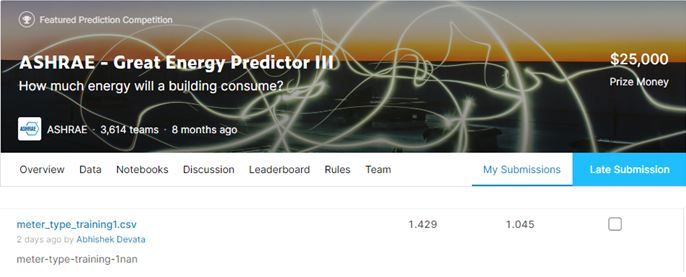

In [1]:
from IPython.display import Image
Image(filename='meter_type.JPG')                                                                                                                                                                                                         